vdm 视角下的 ddpm 实现：<https://arxiv.org/abs/2208.11970>
根据优化函数的不同分为三种
1. 直接预测 x0
2. 预测增加的噪声（DDPM） 
3. 预测分布变化的梯度（Score）

In [1]:
import torch
from jaxtyping import jaxtyped
from beartype import beartype as typechecker
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import torchvision as tv

In [14]:
# 超参数定义
from dataclasses import dataclass
import os

@dataclass
class Config:
    # 文件&数据
    data_path: str = "../dataset/mnist"
    save_dir: str = "./checkpoints"
    save_name: str = "vdm-ddpm"
    transform = tv.transforms.Compose([
        tv.transforms.ToTensor(),
        # tv.transforms.Normalize((0.5,), (0.5,))
    ])
    # 训练参数
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    batch_size: int = 1024
    num_workers: int = 4
    lr: float = 1e-4
    num_epochs: int = 100
    # 模型参数
    img_size = 28

g_opt = Config()
os.makedirs(g_opt.save_dir, exist_ok=True)

In [3]:
# 数据集
from torch.utils.data import DataLoader


train_dataset = tv.datasets.MNIST(
    root=g_opt.data_path,
    train=True,
    transform=g_opt.transform,
    download=True
)
test_dataset = tv.datasets.MNIST(
    root=g_opt.data_path,
    train=False,
    transform=g_opt.transform,
    download=True
)
print(f"共有{len(train_dataset)}张训练图片，{len(test_dataset)}张测试图片")
# 数据加载器
train_loader = DataLoader(
    train_dataset,
    batch_size=g_opt.batch_size,
    shuffle=True,
    num_workers=g_opt.num_workers,
    pin_memory=True
)
val_loader = DataLoader(
    test_dataset,
    batch_size=g_opt.batch_size,
    shuffle=False,
    num_workers=g_opt.num_workers,
    pin_memory=True,
)


共有60000张训练图片，10000张测试图片


In [4]:
# Utility
class NoiseScheduler_Linear(nn.Module):
    def __init__(self, steps, start=0.0001, end=0.02):
        super().__init__()
        self.steps = steps
        self.start = start
        self.end = end
        
        # 预计算扩散过程所需的所有变量
        t = torch.linspace(0, 1, self.steps)
        beta_t = self.start + t * (self.end - self.start)
        alpha_t = 1 - beta_t
        alpha_bar_t = torch.cumprod(alpha_t, dim=0)
        sqrt_alpha_bar_t = torch.sqrt(alpha_bar_t)
        sqrt_one_minus_alpha_bar_t = torch.sqrt(1 - alpha_bar_t)
        
        # 注册为buffer（不参与训练的参数）
        self.register_buffer('beta_t', beta_t)
        self.register_buffer('alpha_t', alpha_t)
        self.register_buffer('alpha_bar_t', alpha_bar_t)
        self.register_buffer('sqrt_alpha_bar_t', sqrt_alpha_bar_t)
        self.register_buffer('sqrt_one_minus_alpha_bar_t', sqrt_one_minus_alpha_bar_t)
    
    def forward(self, key: str, t: int) -> Tensor:
        return getattr(self, key)[t]



In [5]:
# ----------------------------------------------------
# 1. 位置/时间嵌入模块
# ----------------------------------------------------
class SinusoidalPositionEmbeddings(nn.Module):
    """
    将标量时间步长 t 转换为一个固定维度的向量。
    来自 "Attention Is All You Need" 论文。
    """
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    def forward(self, time):
        # time: [batch_size, 1]
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings
# ----------------------------------------------------
# 2. 构成U-Net的基本模块
# ----------------------------------------------------
class ResnetBlock(nn.Module):
    """
    一个包含两个卷积层、组归一化、激活函数和时间嵌入的残差块。
    """
    def __init__(self, in_channels, out_channels, *, time_emb_dim=None, groups=8):
        super().__init__()
        
        # 时间嵌入的线性层
        self.mlp = (
            nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, out_channels))
            if time_emb_dim is not None
            else None
        )
        # 第一个卷积块
        self.block1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.norm1 = nn.GroupNorm(groups, out_channels)
        self.act1 = nn.SiLU()
        # 第二个卷积块
        self.block2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.norm2 = nn.GroupNorm(groups, out_channels)
        self.act2 = nn.SiLU()
        # 残差连接的卷积层 (如果输入输出通道数不一致)
        self.res_conv = (
            nn.Conv2d(in_channels, out_channels, kernel_size=1)
            if in_channels != out_channels
            else nn.Identity()
        )
    def forward(self, x, time_emb=None):
        h = self.block1(x)
        h = self.norm1(h)
        h = self.act1(h)
        # 注入时间信息
        if self.mlp is not None and time_emb is not None:
            time_info = self.mlp(time_emb)
            # 将 [batch_size, out_channels] 扩展为 [batch_size, out_channels, 1, 1] 以便相加
            h = h + time_info.unsqueeze(-1).unsqueeze(-1)
        
        h = self.block2(h)
        h = self.norm2(h)
        h = self.act2(h)
        
        return h + self.res_conv(x)
# ----------------------------------------------------
# 3. 完整的 U-Net 模型
# ----------------------------------------------------
class Unet(nn.Module):
    def __init__(
        self,
        dim,
        init_dim=None,
        out_dim=None,
        dim_mults=(1, 2, 4), # 为 MNIST 调整， (1, 2, 4, 8) 对于 28x28 来说太深了
        channels=1,
        self_condition=False,
        resnet_block_groups=4, # 减小 group size 以适应较小的通道数
    ):
        super().__init__()
        # --- 设置维度 ---
        self.channels = channels
        self.self_condition = self_condition
        input_channels = channels * (2 if self_condition else 1)
        
        init_dim = init_dim if init_dim is not None else dim
        self.init_conv = nn.Conv2d(input_channels, init_dim, 7, padding=3)
        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))
        
        # --- 时间嵌入 ---
        time_dim = dim * 4
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(dim),
            nn.Linear(dim, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, time_dim),
        )
        
        # --- U-Net 层 ---
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        # --- 下采样（编码器）---
        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)
            self.downs.append(
                nn.ModuleList(
                    [
                        ResnetBlock(dim_in, dim_in, time_emb_dim=time_dim, groups=resnet_block_groups),
                        ResnetBlock(dim_in, dim_in, time_emb_dim=time_dim, groups=resnet_block_groups),
                        # FIX #1: 残差连接要匹配通道数
                        nn.Conv2d(dim_in, dim_out, 1) if dim_in != dim_out else nn.Identity(),
                        nn.Conv2d(dim_out, dim_out, kernel_size=4, stride=2, padding=1) if not is_last else nn.Conv2d(dim_out, dim_out, 3, padding=1)
                    ]
                )
            )

        # --- 中间瓶颈层 ---
        mid_dim = dims[-1]
        self.mid_block1 = ResnetBlock(mid_dim, mid_dim, time_emb_dim=time_dim, groups=resnet_block_groups)
        self.mid_block2 = ResnetBlock(mid_dim, mid_dim, time_emb_dim=time_dim, groups=resnet_block_groups)

        # --- 上采样（解码器）---
        for ind, (dim_in, dim_out) in enumerate(reversed(in_out)):
            is_last = ind >= (num_resolutions - 1)
            self.ups.append(
                nn.ModuleList(
                    [
                        # FIX #2: 上采样后通道数是 dim_out + dim_in (来自 skip)
                        ResnetBlock(dim_out + dim_in, dim_out, time_emb_dim=time_dim, groups=resnet_block_groups),
                        ResnetBlock(dim_out + dim_in, dim_out, time_emb_dim=time_dim, groups=resnet_block_groups),
                        nn.Conv2d(dim_out, dim_in, 1) if dim_in != dim_out else nn.Identity(),
                        nn.ConvTranspose2d(dim_in, dim_in, kernel_size=4, stride=2, padding=1) if not is_last else nn.Conv2d(dim_in, dim_in, 3, padding=1)
                    ]
                )
            )
            
        # --- 输出层 ---
        out_dim = out_dim if out_dim is not None else channels
        self.final_res_block = ResnetBlock(init_dim * 2, init_dim, time_emb_dim=time_dim, groups=resnet_block_groups)
        self.final_conv = nn.Conv2d(init_dim, out_dim, 1)

    def forward(self, x, time, x_self_cond=None):
        if self.self_condition:
            x_self_cond = x_self_cond if x_self_cond is not None else torch.zeros_like(x)
            x = torch.cat((x_self_cond, x), dim=1)

        x = self.init_conv(x)
        r = x.clone()

        t = self.time_mlp(time)
        h = []

        # FIX #3: 正确的下采样和 skip connection 逻辑
        for block1, block2, res_conv, downsample in self.downs:
            x = block1(x, t)
            h.append(x)
            x = block2(x, t)
            h.append(x)
            x = res_conv(x)
            x = downsample(x)

        x = self.mid_block1(x, t)
        x = self.mid_block2(x, t)
        
        # FIX #4: 正确的上采样、skip connection 和 upsample 逻辑
        for block1, block2, res_conv, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t)
            x = torch.cat((x, h.pop()), dim=1)
            x = block2(x, t)
            x = res_conv(x)
            x = upsample(x)
            
        x = torch.cat((x, r), dim=1)

        x = self.final_res_block(x, t)
        
        # FIX #5: 确保有返回值
        return self.final_conv(x)


In [6]:

from jaxtyping import Int, Float
import lightning as L

class VDM_Base(L.LightningModule):
    """
    VDM 基类
    """
    def __init__(self, img_size=28, steps=1000, lr=1e-4):
        super(VDM_Base, self).__init__()
        self.img_size = img_size
        self.steps = steps
        self.lr = lr
        self.unet = Unet(
            dim=32,
            dim_mults=(1,2,2),
            channels=1
        )
        self.scheduler = NoiseScheduler_Linear(steps=self.steps)
    
    @jaxtyped(typechecker=typechecker)
    def q_sample(self, x_0: Float[Tensor, "B 1 H W"], t: Int[Tensor, "B"], noise: Float[Tensor, "B 1 H W"]) -> Float[Tensor, "B 1 H W"]:
        """前向扩散过程：从x_0加噪声到x_t"""
        sqrt_alpha_bar = self.scheduler('sqrt_alpha_bar_t', t).view(-1, 1, 1, 1)
        sqrt_one_minus_alpha_bar = self.scheduler('sqrt_one_minus_alpha_bar_t', t).view(-1, 1, 1, 1)
        x_t = sqrt_alpha_bar * x_0 + sqrt_one_minus_alpha_bar * noise
        return x_t
    
    def forward(self, x, t):
        return self.unet(x, t)

    def training_step(self, batch, batch_idx):
        x0, _ = batch
        t = torch.randint(0, self.steps, (x0.shape[0],), device=self.device).long()
        noise = torch.randn_like(x0)
        xt = self.q_sample(x0, t, noise)
        
        pred = self(xt, t)
        
        loss = self.compute_loss(pred, x0, noise, t)
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def compute_loss(self, pred, x0, noise, t):
        raise NotImplementedError

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

    @torch.no_grad()
    def sample(self, n_samples):
        raise NotImplementedError

In [7]:

class VDM_X0(VDM_Base):
    """
    直接预测 x0 的 VDM 模型
    """
    def __init__(self, img_size=28, steps=1000, lr=1e-4):
        super(VDM_X0, self).__init__(img_size=img_size, steps=steps, lr=lr)

    def compute_loss(self, pred_x0, x0, noise, t):
        return F.mse_loss(pred_x0, x0)

    @torch.no_grad()
    def sample(self, n_samples):
        x_t = torch.randn((n_samples, 1, self.img_size, self.img_size), device=self.device)
        self.scheduler.to(self.device)
        for t in reversed(range(self.steps)):
            t_tensor = torch.full((n_samples,), t, device=self.device, dtype=torch.long)
            
            # predict x0
            pred_x0 = self(x_t, t_tensor)

            # estimate noise
            sqrt_alpha_bar_t = self.scheduler('sqrt_alpha_bar_t', t)
            sqrt_one_minus_alpha_bar_t = self.scheduler('sqrt_one_minus_alpha_bar_t', t)
            pred_noise = (x_t - sqrt_alpha_bar_t * pred_x0) / sqrt_one_minus_alpha_bar_t

            # get x_{t-1}
            alpha_t = self.scheduler('alpha_t', t)
            beta_t = self.scheduler('beta_t', t)
            
            x_t = (1 / torch.sqrt(alpha_t)) * (x_t - (beta_t / sqrt_one_minus_alpha_bar_t) * pred_noise)
            if t > 0:
                noise = torch.randn_like(x_t)
                x_t += torch.sqrt(beta_t) * noise
        return x_t



In [8]:
class VDM_Noise(VDM_Base):
    """
    预测噪声的 VDM 模型 (DDPM 的 VDM 实现)
    """
    def __init__(self, img_size=28, steps=1000, lr=1e-4):
        super(VDM_Noise, self).__init__(img_size=img_size, steps=steps, lr=lr)

    def compute_loss(self, pred_noise, x0, noise, t):
        return F.mse_loss(pred_noise, noise)

    @torch.no_grad()
    def sample(self, n_samples):
        x_t = torch.randn((n_samples, 1, self.img_size, self.img_size), device=self.device)
        self.scheduler.to(self.device)
        for t in reversed(range(self.steps)):
            t_tensor = torch.full((n_samples,), t, device=self.device, dtype=torch.long)
            
            # predict noise
            pred_noise = self(x_t, t_tensor)

            # get x_{t-1}
            alpha_t = self.scheduler('alpha_t', t)
            sqrt_one_minus_alpha_bar_t = self.scheduler('sqrt_one_minus_alpha_bar_t', t)
            beta_t = self.scheduler('beta_t', t)
            
            x_t = (1 / torch.sqrt(alpha_t)) * (x_t - (beta_t / sqrt_one_minus_alpha_bar_t) * pred_noise)
            if t > 0:
                noise = torch.randn_like(x_t)
                x_t += torch.sqrt(beta_t) * noise
        return x_t

In [ ]:
class VDM_Score(VDM_Base):
    """
    分数预测角度的 VDM 模型
    """
    def __init__(self, img_size=28, steps=1000, lr=1e-4):
        super(VDM_Score, self).__init__(img_size=img_size, steps=steps, lr=lr)

    def compute_loss(self, pred_score, x0, noise, t):
        sqrt_one_minus_alpha_bar_t = self.scheduler('sqrt_one_minus_alpha_bar_t', t).view(-1, 1, 1, 1)
        target_score = -noise / sqrt_one_minus_alpha_bar_t
        weight = 1.0 - self.scheduler('alpha_t', t).view(-1, 1, 1, 1)
        loss_raw =  F.mse_loss(pred_score, target_score, reduction='none')
        return torch.mean(weight * loss_raw).mean()

    @torch.no_grad()
    def sample(self, n_samples):
        x_t = torch.randn((n_samples, 1, self.img_size, self.img_size), device=self.device)
        self.scheduler.to(self.device)
        for t in reversed(range(self.steps)):
            t_tensor = torch.full((n_samples,), t, device=self.device, dtype=torch.long)
            
            # predict score
            pred_score = self(x_t, t_tensor)

            # estimate noise from score
            sqrt_one_minus_alpha_bar_t = self.scheduler('sqrt_one_minus_alpha_bar_t', t).view(-1, 1, 1, 1)
            pred_noise = -sqrt_one_minus_alpha_bar_t * pred_score

            # get x_{t-1}
            alpha_t = self.scheduler('alpha_t', t).view(-1, 1, 1, 1)
            beta_t = self.scheduler('beta_t', t).view(-1, 1, 1, 1)
            
            x_t = x_t = (1 / torch.sqrt(alpha_t)) * (x_t + beta_t * pred_score)
            if t > 0:
                noise = torch.randn_like(x_t)
                x_t += torch.sqrt(beta_t).view(-1, 1, 1, 1) * noise
        return x_t

In [10]:

import math
from lightning.pytorch.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

def visualize_samples(model, n_samples):
    samples = model.sample(n_samples)
    grid_img = tv.utils.make_grid(samples, nrow=int(math.sqrt(n_samples)))
    plt.figure(figsize=(8, 8))
    plt.imshow(grid_img.permute(1, 2, 0).cpu().numpy())
    plt.axis('off')
    plt.show()

def train_and_eval(model: L.LightningModule, train_loader, val_loader, epochs=10):
    trainer = L.Trainer(
        max_epochs=epochs,
        accelerator=g_opt.device,
        devices=[1],
        log_every_n_steps=10,    
        precision='bf16-mixed' 
    )
    trainer.fit(model, train_loader, val_loader)
    # 可视化
    visualize_samples(model, 16)

Using bfloat16 Automatic Mixed Precision (AMP)
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/data2/ChengJinjun/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/data2/ChengJinjun/.venv/lib/pyth

Epoch 49: 100%|██████████| 59/59 [00:12<00:00,  4.56it/s, v_num=19, train_loss=0.0443]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 59/59 [00:13<00:00,  4.48it/s, v_num=19, train_loss=0.0443]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.08304492..1.1050062].


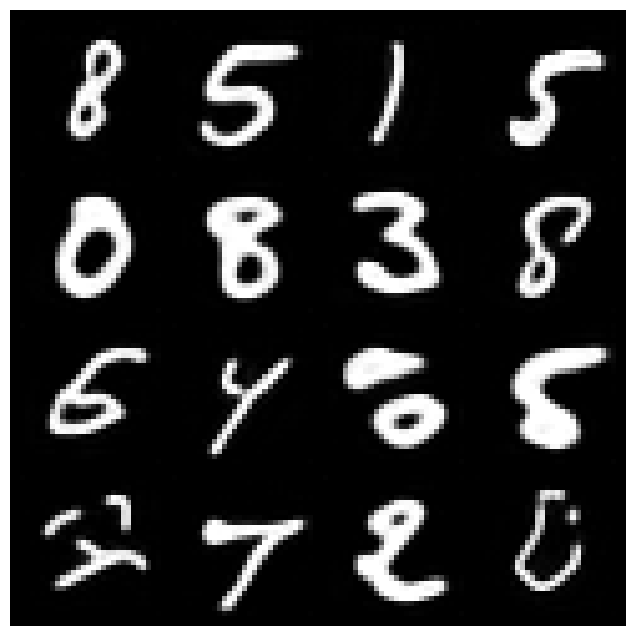

In [11]:
model = VDM_X0(img_size=g_opt.img_size, steps=1000, lr=g_opt.lr)
train_and_eval(model, train_loader, val_loader, epochs=g_opt.num_epochs)

Using bfloat16 Automatic Mixed Precision (AMP)
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name      | Type                  | Params | Mode 
------------------------------------------------------------
0 | unet      | Unet                  | 1.2 M  | train
1 | scheduler | NoiseScheduler_Linear | 0      | train
------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.914     Total estimated model params size (MB)
194       Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 59/59 [00:12<00:00,  4.55it/s, v_num=20, train_loss=0.019] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 59/59 [00:13<00:00,  4.47it/s, v_num=20, train_loss=0.019]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.097784504..1.3325502].


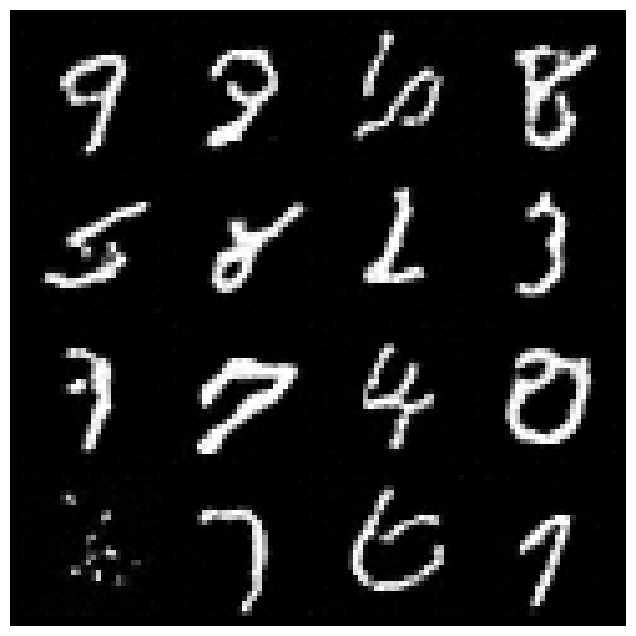

In [12]:

model = VDM_Noise(img_size=g_opt.img_size, steps=1000, lr=g_opt.lr)
train_and_eval(model, train_loader, val_loader, epochs=g_opt.num_epochs)

Using bfloat16 Automatic Mixed Precision (AMP)
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/data2/ChengJinjun/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/data2/ChengJinjun/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:231: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name      | Type                  | Params | Mode 
------------------------------------------------------------
0 | unet      | Unet  

Epoch 499: 100%|██████████| 59/59 [00:13<00:00,  4.53it/s, v_num=33, train_loss=0.00114] 

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 499: 100%|██████████| 59/59 [00:13<00:00,  4.44it/s, v_num=33, train_loss=0.00114]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.024282152..1.0082322].


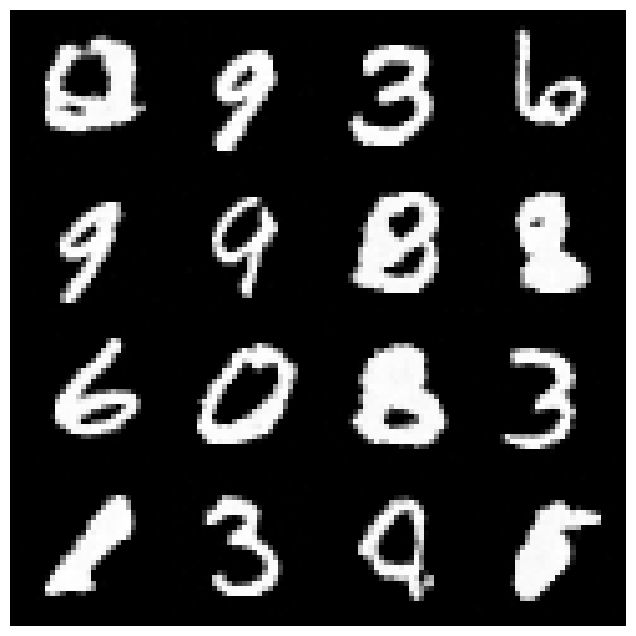

In [39]:
model = VDM_Score(img_size=g_opt.img_size, steps=1000, lr=g_opt.lr)
train_and_eval(model, train_loader, val_loader, epochs=g_opt.num_epochs)